In [1]:
import torch 
from torch import nn
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset ,DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
from torchvision.models import resnet18 , ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

device = 'gpu'


In [3]:
model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
params


11689512

In [5]:
model.fc


Linear(in_features=512, out_features=1000, bias=True)

In [6]:
model.conv1


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [7]:
numFeatures = model.fc.in_features

model.conv1 = nn.Conv2d(1,64,(7,7),stride=(2,2),padding=(3,3),bias=False)

model.fc = nn.Sequential(
    nn.Linear(numFeatures,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,10)
)


In [8]:
model


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
params


11304138

In [10]:

transform = transforms.ToTensor()


In [11]:
mnist = MNIST("./",train=True,transform=transform,download=True)


In [12]:
trainData , valData = train_test_split(mnist,test_size=.2,random_state=42)


In [13]:
testMnist = MNIST("./",train=False,transform=transform,download=True)


In [14]:
trainLoader = DataLoader(trainData,batch_size=32,shuffle=True)
valLoader = DataLoader(valData,batch_size=32)
testLoader = DataLoader(testMnist,batch_size=32)


torch.Size([32, 1, 28, 28])
tensor([2, 7, 8, 9, 3, 1, 2, 6, 7, 3, 9, 8, 8, 5, 2, 8, 3, 1, 0, 8, 9, 7, 7, 6,
        3, 5, 0, 6, 1, 6, 8, 9])


Text(0.5, 1.0, '2')

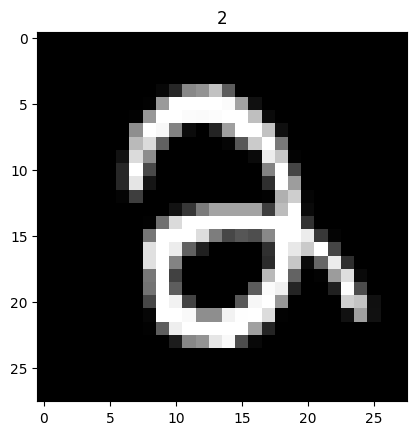

In [15]:

dataiter = iter(trainLoader)
images, labels = next(dataiter)
print(images.shape)  
print(labels)        
plt.imshow(images[0].permute(1,2,0),cmap="gray")
plt.title(labels[0].item())


In [16]:
lossFun = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(model.parameters(),lr=0.01)


In [17]:
def train(model,dataLoader,LossFun,optimizer,device='cuda'):
    model.train()
    for batch , (x,y) in tqdm(enumerate(dataLoader)):
        lossTrain = 0 
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        optimizer.zero_grad()
        loss = lossFun(pred,y)
        lossTrain +=loss
        loss.backward()
        optimizer.step()
    return lossTrain


In [18]:
def test(model,dataLoader,LossFun,device='cuda'):
    model.eval()
    size = len(dataLoader.dataset)
    numBatches = len(dataLoader)
    testLoss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataLoader:
            X = X.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.long)
            pred = model(X)
            testLoss += LossFun(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    testLoss /= numBatches
    correct /= size
    accuracy = 100. * correct
    return testLoss, accuracy


In [19]:
epochs = 10
model.to('cuda')

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}\n-------------------------------")

    # Training
    trainLoss = train(model,trainLoader, lossFun, optimizer,'cuda')

    # Validation
    validationLoss, accuracy = test(model, valLoader, lossFun, device='cuda')

    # Update learning rate scheduler based on validation loss
    # lr_scheduler.step(validation_loss)

    print(f"Epoch {epoch+1}, Train Loss: {trainLoss:.4f}, Validation Loss: {validationLoss:.4f}, Accuracy: {accuracy:.2f}%")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1
-------------------------------


1500it [00:37, 40.16it/s]
 10%|█         | 1/10 [00:40<06:04, 40.45s/it]

Epoch 1, Train Loss: 0.4144, Validation Loss: 0.2666, Accuracy: 91.97%
Epoch 2
-------------------------------


593it [00:13, 42.56it/s]
 10%|█         | 1/10 [00:54<08:09, 54.39s/it]


KeyboardInterrupt: 

In [ ]:
torch.save(model,'./best.pt')


In [ ]:
model = "./best.pt"
model = torch.load(model, map_location=torch.device("cuda:0"))


/tmp/ipykernel_32480/740362129.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model, map_location=torch.device("cuda:0"))


In [ ]:
model


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

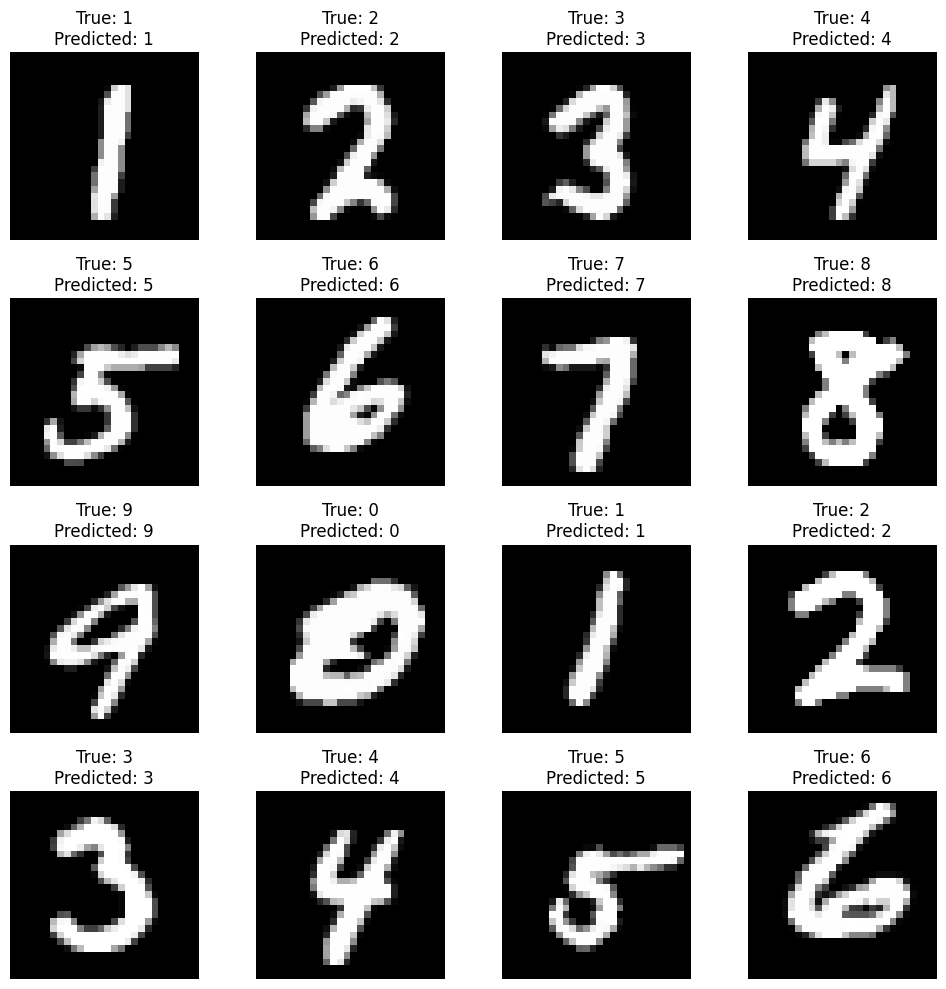

In [ ]:
model.eval()

class_labels = [str(i) for i in range(10)]

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

with torch.no_grad():
    for i, (images, labels) in enumerate(testLoader):
        outputs = model(images.to("cuda"))
        _, predicted = torch.max(outputs, 1)

        for j in range(min(len(images), 16)):
            image = images[j].squeeze().numpy()
            true_label = class_labels[labels[j].item()]
            predicted_label = class_labels[predicted[j].item()]

            ax = axs[j // 4, j % 4]
            ax.imshow(image, cmap='gray')
            ax.axis('off')
            ax.set_title(f'True: {true_label}\nPredicted: {predicted_label}')
plt.tight_layout()
plt.show()
